In [145]:
%matplotlib inline

In [146]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# silence warnings
import warnings
import cv2
from sklearn.metrics import f1_score
import csv
import pandas as pd
warnings.filterwarnings("ignore")

# Facial Recognition with Eigenface


### Abstract
- at first I was going to use a siamese network to verify identification of a person in a database or not and then return the name with the highest correlation from that database...
- I realized that this method is too much overhead for the task at hand with the existence of 'eigenvectors' (cite: Sirovich and Kirby , Al(1987) )
- Alternatively I also recognize that using `face_recognition` library in python is a valid alternative


How does eigenface work? 
- covariance matrix of the probability distribution over the high-dimensional vector space of face images
- classify by comparing how faces are represented by the basis set


Citations: 



# reading the images 

In [205]:
PATH_CUR = '/Users/vera/Courses/projectCV/eigenface/example/eigenfaces/Photos'
PATH_CLEAN = '/Users/vera/Courses/projectCV/eigenface/example/eigenfaces/photos_cleaned/'

In [206]:
import numpy as np
import mediapipe as mp
import cv2
import os

mp_drawing = mp.solutions.drawing_utils

# load face detection model
mp_face = mp.solutions.face_detection.FaceDetection(
    model_selection=1,
    min_detection_confidence=0.5
)
path =  PATH_CUR

new_path = PATH_CLEAN

if not os.path.exists(new_path):
    os.makedirs(new_path)

for file in os.listdir(path):
    img = cv2.imread(path + "/" + file)
    image_input = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = mp_face.process(image_input)
    height, width, _ = img.shape
    detection_results= []
    for detection in results.detections:
        bbox = detection.location_data.relative_bounding_box
        bbox_points = {
            "xmin" : int(bbox.xmin * width),
            "ymin" : int(bbox.ymin * height),
            "xmax" : int(bbox.width * width + bbox.xmin * width),
            "ymax" : int(bbox.height * height + bbox.ymin * height)
        }
        detection_results.append(bbox_points)

    for i, bbox in enumerate(detection_results):
        face = img[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
        cv2.imwrite(new_path + file, face)
        
    

In [207]:
IMAGE_DIR = '/Users/vera/Courses/projectCV/eigenface/example/eigenfaces/photos_cleaned'
DEFAULT_SIZE = [250, 250] 

def read_images(default_size, path):
    images = []
    images_names = []
        # remove the extension at the end of the file name
    for image in os.listdir(path): 
        image_name = os.path.splitext(image)[0]
        image = Image.open(path + "/" + image)
        image = image.convert("L")
        # resize to given size (if given )
        if (default_size is not None ):
            image = image.resize(default_size , Image.ANTIALIAS )
        images.append(np.asarray(image , dtype =np. uint8 ))
        images_names.append(image_name)
    return [images , images_names]

read_images(DEFAULT_SIZE, IMAGE_DIR)

[[array([[ 20,  10,  12, ...,   3,   3,   3],
         [ 12,   9,  14, ...,   8,  11,   8],
         [ 10,  13,  19, ...,   1,   6,   8],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
  array([[129, 135, 134, ..., 142, 142, 140],
         [131, 134, 135, ..., 142, 142, 140],
         [131, 132, 135, ..., 142, 141, 141],
         ...,
         [129, 132, 142, ..., 122, 118, 115],
         [127, 137, 154, ..., 121, 118, 115],
         [131, 139, 147, ..., 123, 118, 114]], dtype=uint8),
  array([[ 58,  56,  53, ..., 112, 115, 116],
         [ 58,  56,  53, ..., 110, 113, 115],
         [ 58,  56,  53, ..., 108, 110, 113],
         ...,
         [181, 182, 182, ..., 184, 185, 185],
         [181, 181, 181, ..., 185, 185, 185],
         [181, 181, 181, ..., 186, 186, 185]], dtype=uint8),
  array([[ 34,  34,  34, ...,  40,  40,  41],
         [ 32,  33,  35, ...,  38,  38,

In [230]:
def as_row_matrix(X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c 
    return mat

as_row_matrix(read_images( DEFAULT_SIZE, IMAGE_DIR)[0]).shape

(28, 62500)

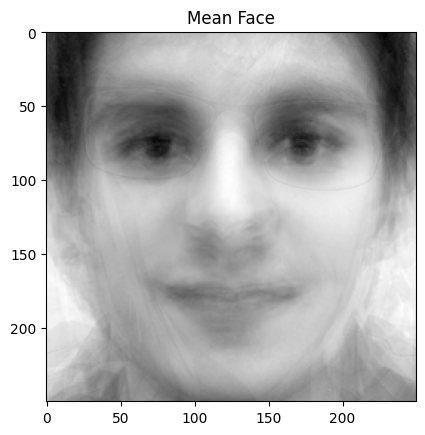

In [209]:
[X, y] = read_images(DEFAULT_SIZE, IMAGE_DIR)    
average_weight_matrix = np.reshape(as_row_matrix(X).mean( axis =0), X[0].shape)
plt.imshow(average_weight_matrix, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

In [231]:
def get_number_of_components_to_preserve_variance(eigenvalues, variance=.95):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii
        
        
def pca(X, y, num_components =0):
    [n,d] = X.shape
    if ( num_components <= 0) or ( num_components >n):
        num_components = n
        mu = X.mean( axis =0)
        X = X - mu
    if n>d:
        C = np.dot(X.T,X) # Covariance Matrix
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    else :
        C = np.dot (X,X.T) # Covariance Matrix
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T, eigenvectors )
        for i in range (n):
            eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort (- eigenvalues )
    eigenvalues = eigenvalues [idx ]
    eigenvectors = eigenvectors [:, idx ]
    num_components = get_number_of_components_to_preserve_variance(eigenvalues)
    # select only num_components
    eigenvalues = eigenvalues [0: num_components ].copy ()
    eigenvectors = eigenvectors [: ,0: num_components ].copy ()
    return [ eigenvalues , eigenvectors , mu]  

[eigenvalues, eigenvectors, mean] = pca(as_row_matrix(X), y)

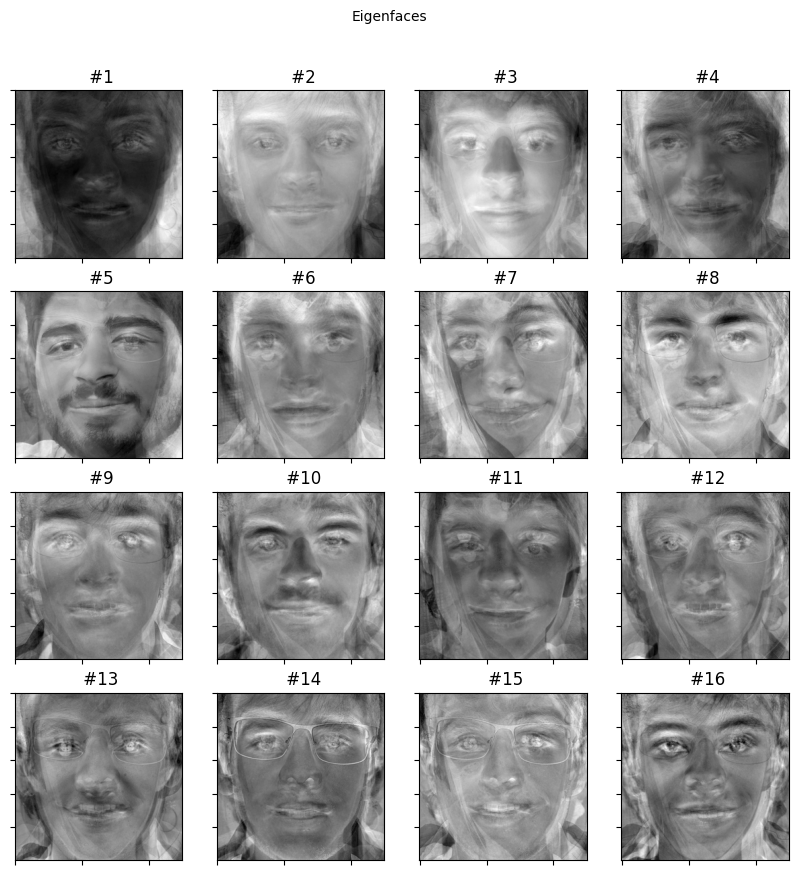

In [233]:
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10) ):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )

        
E = []
number = eigenvectors.shape[1]
for i in range (min(number, 16 )):
    e = eigenvectors[:,i].reshape(X[0].shape )
    E.append(np.asarray(e))
subplot(title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="python_pca_eigenfaces.png")

Cumulative sum of first highest eigenvalues is given below. Based on the plot it's clear we should pick these features.

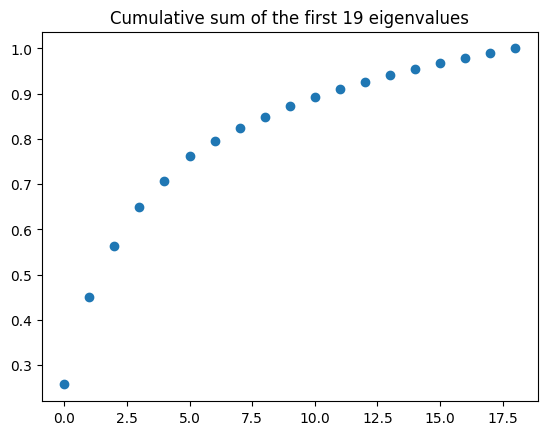

In [234]:
def get_eigen_value_distribution(eigenvectors):
    return np.cumsum(eigenvectors) / np.sum(eigenvectors)

def plot_eigen_value_distribution(eigenvectors, interval):
    plt.scatter(interval, get_eigen_value_distribution(eigenvectors)[interval])

plot_eigen_value_distribution(eigenvalues, range(0, number))
plt.title("Cumulative sum of the first {0} eigenvalues".format(number))
plt.show()

##### Representing faces onto this basis

The reconstruction from the PCA basis is given by:

$x = W y + \mu$

where $W = (v_{1}, v_{2}, \ldots, v_{k})$.

Now we **reconstruct** the first image from smaller training set:

In [235]:

def project(W , X , mu):
    return np.dot (X - mu , W)
def reconstruct(W , Y , mu) :
    return np.dot (Y , W.T) + mu


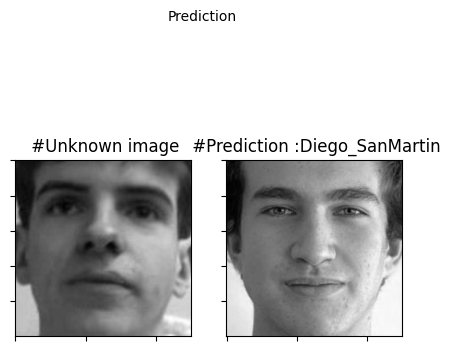

In [236]:
def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray (q).flatten()
    return np.sqrt (np.sum (np. power ((p-q) ,2)))

def predict (W, mu , projections, y, X):
    minDist = float("inf")
    minClass = -1
    Q = project(W, X.reshape (1 , -1) , mu)
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

def inference(): 
    projections = []
    for xi in X:
        projections.append(project (eigenvectors, xi.reshape(1 , -1) , mean))
    image = Image.open("test.jpg")
    image = image.convert("L")
    if (DEFAULT_SIZE is not None ):
        image = image.resize(DEFAULT_SIZE , Image.ANTIALIAS )
    test_image = np.asarray(image , dtype =np. uint8 )
    predicted = predict(eigenvectors, mean , projections, y, test_image)
    return predicted, test_image

def inference_plot(predicted, test_image):
    subplot(title ="Prediction", images =[test_image, X[predicted]], rows =1, cols =2, 
            sptitles = ["Unknown image", "Prediction :{0}".format(y[predicted])] , colormap =plt.cm.gray , 
            filename ="prediction_test.png", figsize = (5,5))
    
predicted, test_image = inference()
inference_plot(predicted, test_image)


# Inference


In [237]:
ground_truth = { 
"No face":0,
"Unknown":1 ,
"Alejandro_Galvez":2 ,
"Alejandro_Perez":3 ,
"Antonio_Fernandez":4,
"Bartosz_Rzycki":5 ,
"Beltran_Valle":6,
"Boumediene_Rayane":7 ,
"Carlo_Pastor":8 ,
"Carlos_Tapia":9,
"Diego_SanMartin":10 ,
"Dyanna_Monique_Rivera":11 ,
"Farah_Abuatiyeh":12, 
"Francisco_Heshiki":13,
"Henning_Gruhl":14 ,
"Ignacio_Chirinos":15 ,
"Ismael_Doukkali":16,
"Joaquin_Casasus":17,
"Juan_Jose_Rubiales":18,
"Lorenz_Ehrlich":19,
"Manuel_SanRomanGarcia":20,
"Marta_Garcia":21,
"Mikhaile_Collins":22,
"Pablo_Ortega":23,
"Rabindra_Adhikari":24,
"Tamar_Alphaidze":25,
"Tomas_Vintimilla":26,
"Vera_Prohaska":27,
"Yahya_Laraqui":28,
"Yousif_Alsaffar":29}

In [238]:
#change the format of the dictionary, so that the key is the number and the value is the name
ground_truth = {v: k for k, v in ground_truth.items()}
ground_truth[0] = "Unknown"

In [239]:
def parse_yolo_format(file_path):
    '''
    This function parses the yolo format and returns the ground truth label

    Input:
    file_path: path to the yolo file

    Output:
    ground_truth: ground truth label

    '''
    with open(file_path, 'r') as file:
        line = file.readlines()
        label = line[0].split(' ')[0]
        bbox = line[0].split(' ')[1:]
        bbox = [float(i) for i in bbox]
        

    return ground_truth[int(label)]

#Example with the 210th frame of the video of Yahya
yolo_file_path = 'Labels/labelled_frames_Video_Yahya_Laraqui/210.txt'
parsed_data = parse_yolo_format(yolo_file_path)
print(parsed_data)

Unknown


In [240]:
dicc_Rayane = {"author" : "Rayane","label_link" : 'labels/labelled_frames_Video_Boumediene_Rayane/' , "n_labels" : 5856 }
dicc_Yahya = {"author" : "Yahya", "label_link" : 'labels/labelled_frames_Video_Yahya_Laraqui/' , "n_labels" : 5227 }
dicc_Francisco = {"author": "Francisco", "label_link" : 'labels/labelled_frames_Video_Francisco_Heshiki/Video_Francisco_Heshiki_0000' , "n_labels" : 6457 }
def takeLabels(dicc):
    '''
    This function takes the labels of the frames of a video and returns a list with the labels
    
    Input:
    dicc: dictionary with the author of the video, the link to the labels and the number of labels
    
    Output:
    labels: list with the labels of the frames of the video
    '''
    
    labels = []
    for i in range(1, dicc["n_labels"]+1):
        if dicc["author"] == "Francisco":
            yolo_file_path = dicc["label_link"] + str(i).zfill(4)+'.txt'
        else:
            yolo_file_path = dicc["label_link"] +str(i)+'.txt'
        parsed_data = parse_yolo_format(yolo_file_path)
        labels.append(parsed_data)
    return labels

labelsRayane = takeLabels(dicc_Rayane)
labelsYahya = takeLabels(dicc_Yahya)
#labelsFrancisco = takeLabels(dicc_Francisco)


In [241]:
len(labelsRayane), len(labelsYahya)#, len(labelsFrancisco)

(5856, 5227)

In [242]:
def crop_face(img):
    #image_input = cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB)
    results = mp_face.process(img)

    if not results.detections:
        return None
    else:
        height, width, _ = img.shape
        detection_results= []
        for detection in results.detections:
            bbox = detection.location_data.relative_bounding_box
            bbox_points = {
                "xmin" : int(bbox.xmin * width),
                "ymin" : int(bbox.ymin * height),
                "xmax" : int(bbox.width * width + bbox.xmin * width),
                "ymax" : int(bbox.height * height + bbox.ymin * height)
            }
            detection_results.append(bbox_points)
        # Crop face from image
            # Crop face from image
        for i, bbox in enumerate(detection_results):
            face = img[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
            if len(face) == 0: 
                return None
            return face

In [244]:
#predicted labels
predicted_labels = []

#videos
video1="videos/Video_Boumediene_Rayane.mp4"
video2="videos/Video_Yahya_Laraqui.mp4"
video3="videos/Video_Francisco_Heshiki.mp4" 

#load camera
cap= cv2.VideoCapture(video1)

# take all the photos from the video
while True:
    ret, frame = cap.read()
    x = crop_face(frame)
    if x is not None:
        cv2.imwrite('test.jpg',x)
        predicted = inference()
        print(y[predicted[0]])
        predicted_labels.append(predicted)
    else: 
        predicted_labels.append("Unknown")

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()
    
    



Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_Heshiki
Francisco_

error: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'
